In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import statsmodels.api as sm


# Add .. to the path
import sys
sys.path.append("..")

import src.utils as utils

plt.rcParams.update({"font.size": 9})
plt.rc("text", usetex=True)

<Axes: >

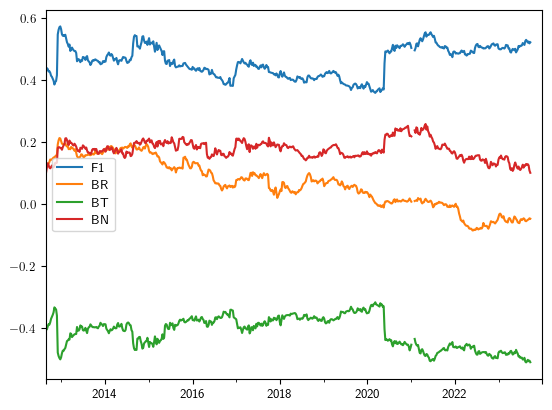

In [2]:
data_raw = pd.read_pickle("../data/interim/voyager/voyager1_lism_cleaned.pkl")
data_raw.resample("7D").mean().plot()

In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7461001 entries, 2012-08-25 00:00:00 to 2023-12-31 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   F1      float32
 1   BR      float32
 2   BT      float32
 3   BN      float32
dtypes: float32(4)
memory usage: 170.8 MB


In [4]:
# First, convert DOY to date
doy_to_date = lambda year, doy: datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)

# Extract interval I2
start_date = doy_to_date(2014, 184)
# End data = start_date + 6 months
end_date = start_date + datetime.timedelta(6*30)

data = data_raw[start_date:end_date]

# Extract different intervals
#data = data_raw[doy_to_date(2014, 1) : doy_to_date(2018, 30)]

#data.resample("6h").mean().plot()
# plt.title("Interval I2 from Fraternale et al. (2021)")

In [5]:
# Resample to 288s
#data = data.resample("288s").mean()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324001 entries, 2014-07-03 00:00:00 to 2014-12-30 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      78932 non-null  float32
 1   BR      78932 non-null  float32
 2   BT      78932 non-null  float32
 3   BN      78932 non-null  float32
dtypes: float32(4)
memory usage: 7.4 MB


In [6]:
import importlib
importlib.reload(utils)

<module 'src.utils' from 'c:\\Users\\spann\\Documents\\Research\\Code repos\\sf_gap_analysis\\notebooks\\..\\src\\utils.py'>

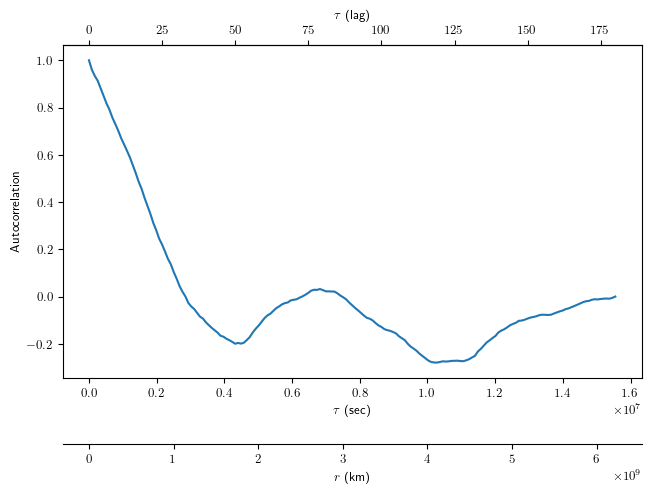

In [7]:
# Plot autocorrelation of F1 component

data_res = data.resample("1D").mean()

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [data_res.F1],
    nlags=len(data_res)-1,
    plot=True,
)

np.float64(1767898.306)

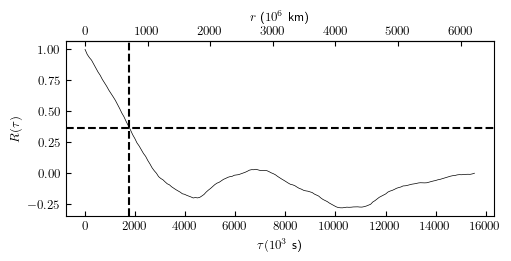

In [8]:
tce, fig, ax = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=True)
tce

In [9]:
tcf, fig, ax = utils.compute_outer_scale_exp_fit(
    time_lags=time_lags_lr,
    acf=r_vec_lr,
    seconds_to_fit=np.round(2 * tce),
    fig=fig,
    ax=ax,
    plot=True,
    initial_guess=tce
)

tcf

np.float64(1563505.7783602036)

In [10]:
tci, fig, ax = utils.compute_outer_scale_integral(
    time_lags_lr, r_vec_lr, fig=fig, ax=ax, plot=True
)
tci
#print(f"tci = {tci/ (24 * 3600):.2f} days")

2764800.0


np.float64(1450897.241297915)

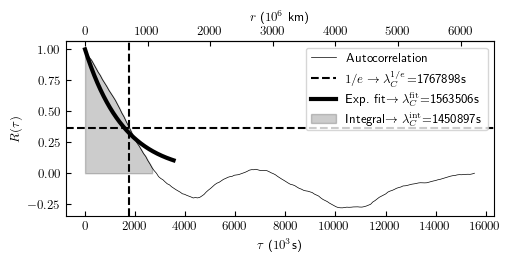

In [11]:
fig

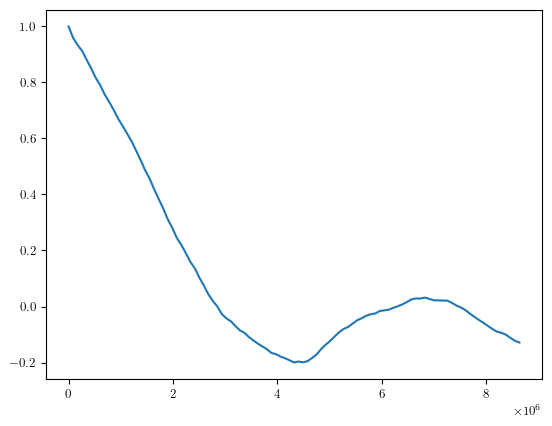

In [12]:
from src.corr_funcs_claude import *

# Basic usage with default units (seconds)
time_lags, acf = compute_nd_acf([data_res.F1], 100)

plt.plot(time_lags, acf)


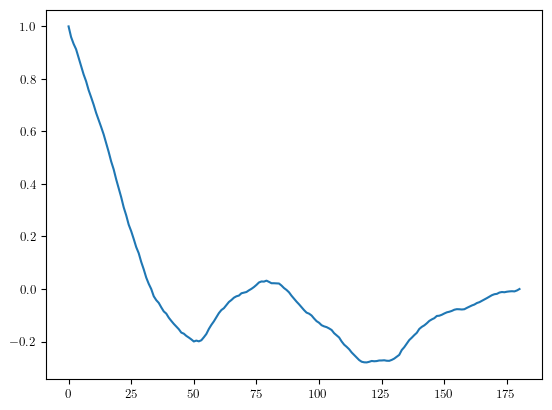

In [13]:
# Using minutes as the output unit
time_lags, acf = compute_nd_acf([data_res.F1], time_unit=TimeUnit.DAYS)
plt.plot(time_lags, acf)

corr_scale_exp_trick = 20.46 days


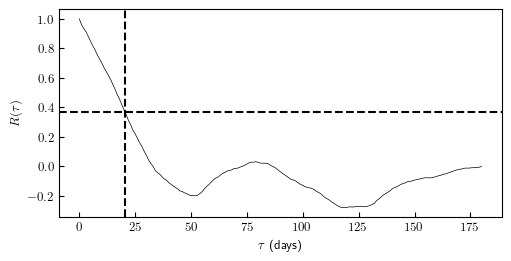

In [14]:
corr_scale_exp_trick, fig, ax = compute_outer_scale_exp_trick(
    time_lags, acf, plot=True, time_unit=TimeUnit.DAYS
)
print(f"corr_scale_exp_trick = {corr_scale_exp_trick:.2f} days")

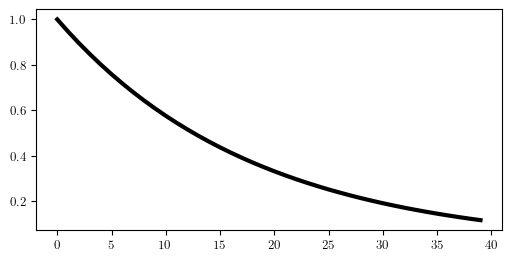

In [15]:
corr_scale_exp_fit = compute_outer_scale_exp_fit(
    time_lags, acf, time_to_fit=2 * corr_scale_exp_trick, plot=True, time_unit=TimeUnit.DAYS
)

(np.float64(16.793),
 <Figure size 500x250 with 1 Axes>,
 <Axes: xlabel='$\\tau$ (days)'>)

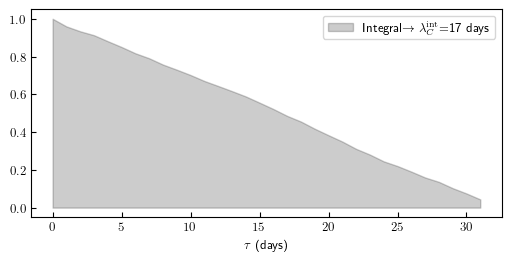

In [16]:
compute_outer_scale_integral(time_lags, acf, plot=True, time_unit=TimeUnit.DAYS)

In [17]:
interval_duration = (data_res.index[-1] - data_res.index[0]).days
interval_duration

180

c:\Users\spann\Documents\Research\Code repos\sf_gap_analysis\notebooks\..\src\corr_funcs_claude.py:455: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\spann\AppData\Local\Temp\ipykernel_12060\208600974.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  results["figure"].show()


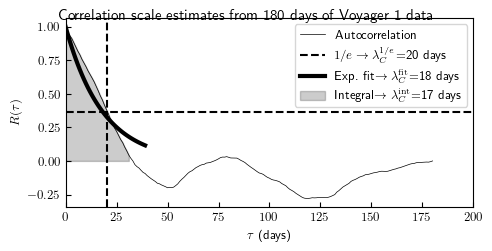

In [20]:
# Getting all correlation scales and a combined plot in days

results = compute_all_correlation_scales(
    [data_res.F1], 
    time_unit=TimeUnit.DAYS, 
    xmax=200, 
    title = f"Correlation scale estimates from {interval_duration} days of Voyager 1 data")

# Add duration to results
results["interval_duration"] = interval_duration

# Show the combined figure
results["figure"].show()

In [ ]:
results

{'correlation_scale_1/e': np.float64(20.462),
 'correlation_scale_exp_fit': np.float64(0.00020944596912050737),
 'correlation_scale_integral': np.float64(16.792792144651795),
 'figure': <Figure size 500x250 with 1 Axes>}

**Correlation lengths from different length intervals of daily averages of F1:**

- 5-6 days for 1 month of data (only 30 points total)
- 9-10 days for 6 months of data
- 16-20 days for just under 1 year of data (int I1 from Fraternale 2021, in line with his results)
- 68-94 days for 2 years of data
- 160-180 days for 4 years of data

## NEXT STEPS

1. Change figure output to have scales in days, not seconds.
1. De-trend the data and re-calculate the correlation lengths.
2. Save plots each time the correlation length is calculated, **with same xlim**
3. Start the interval at start of Frat's I2 (quiescent).


In [20]:
# # Loop over the three estimator functions for different interval lengths and save the results in a dataframe

# int_lengths_days = [50, 100, 200, 400]
# tce_list = []
# tcf_list = []
# tci_list = []

# for int_length in int_lengths_days:
    
#     # Subset the data to the interval length
#     # Get the first int_length days of the data

#     # Convert interval length from days to pandas offset
#     int_length = f"{int_length}D"

#     time_lags_lr, r_vec_lr = utils.compute_nd_acf(
#         [data_res.F1],
#         nlags=len(data_res)-1,
#         plot=False,
#     )

#     tce = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)
#     tcf = utils.compute_outer_scale_exp_fit(
#         time_lags=time_lags_lr,
#         acf=r_vec_lr,
#         seconds_to_fit=np.round(2 * tce),
#         fig=None,
#         ax=None,
#         plot=False,
#         initial_guess=tce
#     )
#     tci = utils.compute_outer_scale_integral(
#         time_lags_lr, r_vec_lr, fig=None, ax=None, plot=False
#     )

#     tce_list.append(tce/ (24 * 3600))
#     tcf_list.append(tcf / (24 * 3600))
#     tci_list.append(tci / (24 * 3600))

# results = pd.DataFrame(
#     {
#         "Interval length [days]": int_lengths_days,
#         "tce [days]": tce_list,
#         "tcf [days]": tcf_list,
#         "tci [days]": tci_list
#     }
# )

## Taylor scale

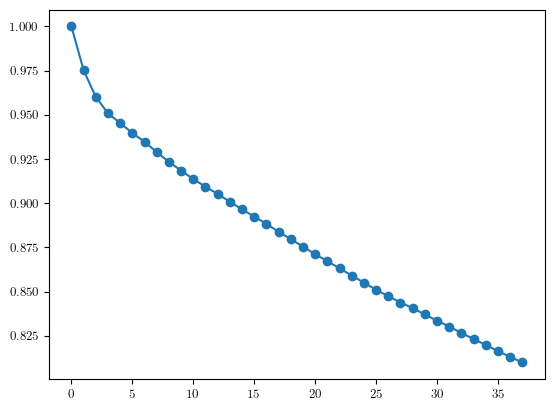

In [22]:
acf = sm.tsa.acf(
    data["F1"], nlags=int(1800/ 48), missing="conservative"
)
plt.plot(acf, marker="o")

This one looks pretty damn similar to Fraternale's Fig 3a inset.